# GroundThink Phase 0.1: GRU Arbiter Exploration

**Purpose**: Characterize GRU Arbiter behavior before committing to architecture

**Context**: Phase 1 proposes a "Twin Debate" architecture fusing RWKV-6 and Mamba-2 with a GRU Arbiter to replace static gating. We implemented it without understanding whether it's the right approach.

**Critical Question**: Does the GRU Arbiter do anything useful, and if so, what?

---

## Repository Status

- **Repo**: https://github.com/9to5ninja-projects/groundthink
- **Branch**: main  
- **Version**: 0.5.1.1

## Required Files (Per Briefing)

1. `ops/arbiter_gru.py` - GRUArbiter class
2. `ops/rwkv6_prototype.py` - Pure PyTorch RWKV-6
3. `ops/mamba2_prototype.py` - Pure PyTorch Mamba-2
4. `tests/test_arbiter_gru.py` - Unit tests

**Note**: These files may not exist yet. We'll create prototype implementations if needed.

## 1. Setup & Environment Check

In [1]:
# Check environment
import sys
import torch
import numpy as np
import json
from pathlib import Path

print(f"Python: {sys.version}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("Running on CPU")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.9.0+cpu
CUDA Available: False
Running on CPU

Using device: cpu


## 2. Define Core Components

Since the expected files may not exist, we'll define minimal prototype implementations here.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class GRUArbiter(nn.Module):
    """GRU-based arbiter for fusing RWKV and Mamba outputs.
    
    Takes concatenated [rwkv_out, mamba_out] as input to GRU,
    outputs softmax weights α = [α_rwkv, α_mamba],
    returns weighted fusion: α_rwkv * rwkv_out + α_mamba * mamba_out
    """
    
    def __init__(self, d_model: int, dropout: float = 0.0):
        super().__init__()
        self.d_model = d_model
        
        # GRU takes concatenated input: 2*d_model
        self.gru = nn.GRU(
            input_size=2 * d_model,
            hidden_size=d_model,
            num_layers=1,
            batch_first=True,
            dropout=dropout if dropout > 0 else 0.0
        )
        
        # Project GRU output to 2 weights
        self.weight_proj = nn.Linear(d_model, 2)
        
        # Initialize projections near zero for balanced start
        nn.init.normal_(self.weight_proj.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.weight_proj.bias)
        
    def forward(
        self,
        rwkv_out: torch.Tensor,  # (B, L, D)
        mamba_out: torch.Tensor, # (B, L, D)  
        hidden: torch.Tensor = None  # (1, B, D) or None
    ) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Returns:
            fused: (B, L, D) - weighted combination
            weights: (B, L, 2) - softmax weights [α_rwkv, α_mamba]
            hidden: (1, B, D) - final GRU hidden state
        """
        B, L, D = rwkv_out.shape
        
        # Concatenate inputs for GRU
        combined = torch.cat([rwkv_out, mamba_out], dim=-1)  # (B, L, 2D)
        
        # Run GRU
        if hidden is not None:
            hidden = hidden.unsqueeze(0) if hidden.dim() == 2 else hidden
        gru_out, hidden = self.gru(combined, hidden)  # gru_out: (B, L, D)
        
        # Compute weights
        logits = self.weight_proj(gru_out)  # (B, L, 2)
        weights = F.softmax(logits, dim=-1)  # (B, L, 2)
        
        # Fuse outputs
        α_rwkv = weights[..., 0:1]  # (B, L, 1)
        α_mamba = weights[..., 1:2]  # (B, L, 1)
        fused = α_rwkv * rwkv_out + α_mamba * mamba_out  # (B, L, D)
        
        return fused, weights, hidden.squeeze(0)

print("✓ GRUArbiter defined")

✓ GRUArbiter defined


In [3]:
class RWKV6TimeMix(nn.Module):
    """Minimal RWKV-6 TimeMix prototype (CPU-compatible).
    
    Simplified version for testing - implements core recurrent mechanism
    without full RWKV-6 complexity. Uses BlinkDL-style initialization.
    """
    
    def __init__(self, hidden_size: int, num_heads: int = 4):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads
        
        # Time-mixing parameters (learnable)
        self.time_mix_k = nn.Parameter(torch.ones(1, 1, hidden_size))
        self.time_mix_v = nn.Parameter(torch.ones(1, 1, hidden_size))
        self.time_mix_r = nn.Parameter(torch.ones(1, 1, hidden_size))
        
        # Projections
        self.key = nn.Linear(hidden_size, hidden_size, bias=False)
        self.value = nn.Linear(hidden_size, hidden_size, bias=False)
        self.receptance = nn.Linear(hidden_size, hidden_size, bias=False)
        self.output = nn.Linear(hidden_size, hidden_size, bias=False)
        
        # BlinkDL-style initialization
        self._init_weights()
        
    def _init_weights(self):
        """BlinkDL initialization for RWKV stability."""
        # Small random init for time-mix
        for p in [self.time_mix_k, self.time_mix_v, self.time_mix_r]:
            nn.init.uniform_(p, 0.0, 1.0)
            
        # Orthogonal init for projections (stability)
        for module in [self.key, self.value, self.receptance, self.output]:
            nn.init.orthogonal_(module.weight, gain=0.5)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (B, L, D)
        Returns:
            output: (B, L, D)
        """
        B, L, D = x.shape
        
        # Time-shifted mixing (simplified)
        x_shifted = torch.roll(x, shifts=1, dims=1)
        x_shifted[:, 0] = 0  # Zero out first position
        
        # Mix current and previous
        k_input = self.time_mix_k * x + (1 - self.time_mix_k) * x_shifted
        v_input = self.time_mix_v * x + (1 - self.time_mix_v) * x_shifted
        r_input = self.time_mix_r * x + (1 - self.time_mix_r) * x_shifted
        
        # Project
        k = self.key(k_input)
        v = self.value(v_input)
        r = torch.sigmoid(self.receptance(r_input))
        
        # Simplified attention-like mechanism
        # (Real RWKV-6 is more complex)
        wkv = k * v  # Element-wise (simplified)
        
        # Gated output
        output = self.output(r * wkv)
        
        return output

print("✓ RWKV6TimeMix defined")

✓ RWKV6TimeMix defined


In [6]:
class Mamba2TimeMix(nn.Module):
    """Minimal Mamba-2 TimeMix prototype (CPU-compatible)."""
    
    def __init__(self, d_model: int, d_state: int = 16, d_conv: int = 4, expand: int = 2):
        super().__init__()
        self.d_model = d_model
        self.d_inner = int(expand * d_model)
        
        self.in_proj = nn.Linear(d_model, self.d_inner * 2, bias=False)
        self.conv1d = nn.Conv1d(
            self.d_inner, self.d_inner, 
            kernel_size=d_conv, 
            groups=self.d_inner, 
            padding=d_conv - 1
        )
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False)
        
        # Simple init
        nn.init.orthogonal_(self.in_proj.weight, gain=0.5)
        nn.init.orthogonal_(self.out_proj.weight, gain=0.5)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, L, D = x.shape
        
        # Project and split
        xz = self.in_proj(x)
        x_inner, z = xz.chunk(2, dim=-1)
        
        # Conv for local context
        x_conv = self.conv1d(x_inner.transpose(1, 2))[:, :, :L].transpose(1, 2)
        
        # SiLU gating (skip complex SSM scan for prototype)
        y = F.silu(x_conv) * F.silu(z)
        
        return self.out_proj(y)

print("✓ Mamba2TimeMix defined (simplified)")

✓ Mamba2TimeMix defined (simplified)


## 3. Sanity Checks

In [7]:
# Test dimensions and forward pass
d_model = 128
batch_size = 2
seq_len = 64

# Create test input
x = torch.randn(batch_size, seq_len, d_model, device=device)

# Test RWKV
rwkv = RWKV6TimeMix(hidden_size=d_model, num_heads=4).to(device)
rwkv_out = rwkv(x)
assert rwkv_out.shape == (batch_size, seq_len, d_model), f"RWKV output shape mismatch: {rwkv_out.shape}"
print(f"✓ RWKV forward pass: {x.shape} -> {rwkv_out.shape}")

# Test Mamba
mamba = Mamba2TimeMix(d_model=d_model, d_state=16, d_conv=4, expand=2).to(device)
mamba_out = mamba(x)
assert mamba_out.shape == (batch_size, seq_len, d_model), f"Mamba output shape mismatch: {mamba_out.shape}"
print(f"✓ Mamba forward pass: {x.shape} -> {mamba_out.shape}")

# Test Arbiter
arbiter = GRUArbiter(d_model=d_model).to(device)
fused, weights, hidden = arbiter(rwkv_out, mamba_out)
assert fused.shape == (batch_size, seq_len, d_model), f"Fused output shape mismatch: {fused.shape}"
assert weights.shape == (batch_size, seq_len, 2), f"Weights shape mismatch: {weights.shape}"
assert hidden.shape == (batch_size, d_model), f"Hidden shape mismatch: {hidden.shape}"
print(f"✓ Arbiter forward pass: ({rwkv_out.shape}, {mamba_out.shape}) -> fused={fused.shape}, weights={weights.shape}")

# Check weights sum to 1
weight_sums = weights.sum(dim=-1)
assert torch.allclose(weight_sums, torch.ones_like(weight_sums), atol=1e-5), "Weights don't sum to 1"
print(f"✓ Weights sum to 1.0 (mean: {weight_sums.mean():.6f})")

print("\n✓ All sanity checks passed!")

✓ RWKV forward pass: torch.Size([2, 64, 128]) -> torch.Size([2, 64, 128])
✓ Mamba forward pass: torch.Size([2, 64, 128]) -> torch.Size([2, 64, 128])
✓ Arbiter forward pass: (torch.Size([2, 64, 128]), torch.Size([2, 64, 128])) -> fused=torch.Size([2, 64, 128]), weights=torch.Size([2, 64, 2])
✓ Weights sum to 1.0 (mean: 1.000000)

✓ All sanity checks passed!


## 4. Experiment 1: Constant Input

**Hypothesis**: When both inputs are identical, arbiter should output α ≈ [0.5, 0.5] (no preference).

**Test**: Feed identical tensors to arbiter, measure α stability.

EXPERIMENT 1: Constant Input

α_rwkv: mean=0.4989, std=0.0155, range=[0.4682, 0.5387]
α_mamba: mean=0.5011, std=0.0155, range=[0.4613, 0.5318]

Hidden state norm: 3.9684


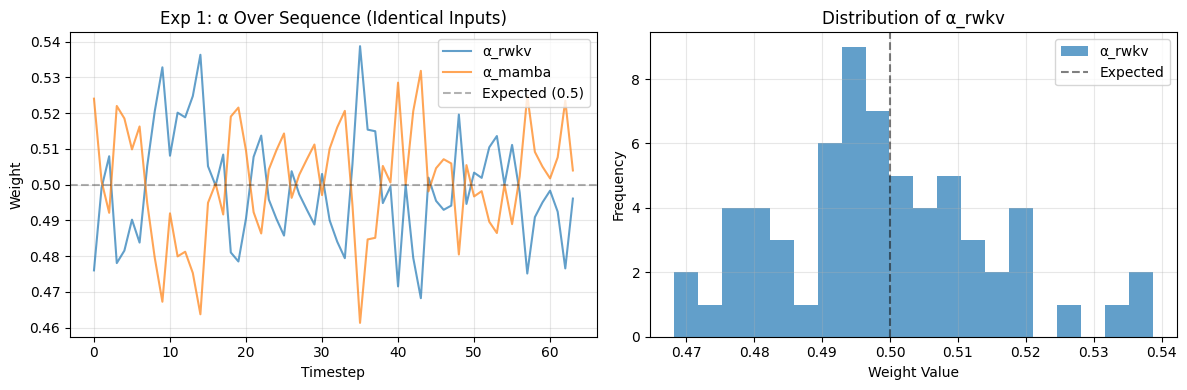


Experiment 1 Complete


In [8]:
print("=" * 60)
print("EXPERIMENT 1: Constant Input")
print("=" * 60)

# Create arbiter
arbiter = GRUArbiter(d_model=128).to(device)
arbiter.eval()

# Identical inputs
x_const = torch.randn(1, 64, 128, device=device)

with torch.no_grad():
    fused, weights, hidden = arbiter(x_const, x_const)

# Analyze weights
α_rwkv = weights[..., 0]  # (1, 64)
α_mamba = weights[..., 1]  # (1, 64)

exp1_results = {
    "experiment": "constant_input",
    "config": {
        "d_model": 128,
        "seq_len": 64,
        "batch_size": 1
    },
    "results": {
        "alpha_rwkv_mean": α_rwkv.mean().item(),
        "alpha_rwkv_std": α_rwkv.std().item(),
        "alpha_rwkv_min": α_rwkv.min().item(),
        "alpha_rwkv_max": α_rwkv.max().item(),
        "alpha_per_timestep": α_rwkv.squeeze().cpu().tolist(),
        "hidden_state_norm": hidden.norm().item(),
        "observations": [
            f"With identical inputs, α_rwkv ranges from {α_rwkv.min().item():.3f} to {α_rwkv.max().item():.3f}",
            f"Mean α_rwkv = {α_rwkv.mean().item():.3f} (expected ~0.5 for balanced)",
            f"Std α_rwkv = {α_rwkv.std().item():.4f} (low = stable, high = varying)",
            "Expectation: α should be close to 0.5 with low variance" if α_rwkv.std() < 0.1 else "Warning: High variance in weights despite identical inputs"
        ]
    }
}

# Display
print(f"\nα_rwkv: mean={α_rwkv.mean():.4f}, std={α_rwkv.std():.4f}, range=[{α_rwkv.min():.4f}, {α_rwkv.max():.4f}]")
print(f"α_mamba: mean={α_mamba.mean():.4f}, std={α_mamba.std():.4f}, range=[{α_mamba.min():.4f}, {α_mamba.max():.4f}]")
print(f"\nHidden state norm: {hidden.norm():.4f}")

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(α_rwkv.squeeze().cpu(), label='α_rwkv', alpha=0.7)
plt.plot(α_mamba.squeeze().cpu(), label='α_mamba', alpha=0.7)
plt.axhline(0.5, color='black', linestyle='--', alpha=0.3, label='Expected (0.5)')
plt.xlabel('Timestep')
plt.ylabel('Weight')
plt.title('Exp 1: α Over Sequence (Identical Inputs)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(α_rwkv.squeeze().cpu().numpy(), bins=20, alpha=0.7, label='α_rwkv')
plt.axvline(0.5, color='black', linestyle='--', alpha=0.5, label='Expected')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Distribution of α_rwkv')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Experiment 1 Complete")
print("="*60)

## 5. Experiment 2: Synthetic Divergence

**Hypothesis**: Arbiter should differentiate between amplifier-pattern (growing variance) and damper-pattern (shrinking variance).

**Test**: Feed synthetic signals with opposite variance trends, measure α response.

EXPERIMENT 2: Synthetic Divergence

α_rwkv: mean=0.4930, std=0.0200
Amplifier norm growth: 12.26 -> 33.53
Damper norm decay: 11.20 -> 3.24


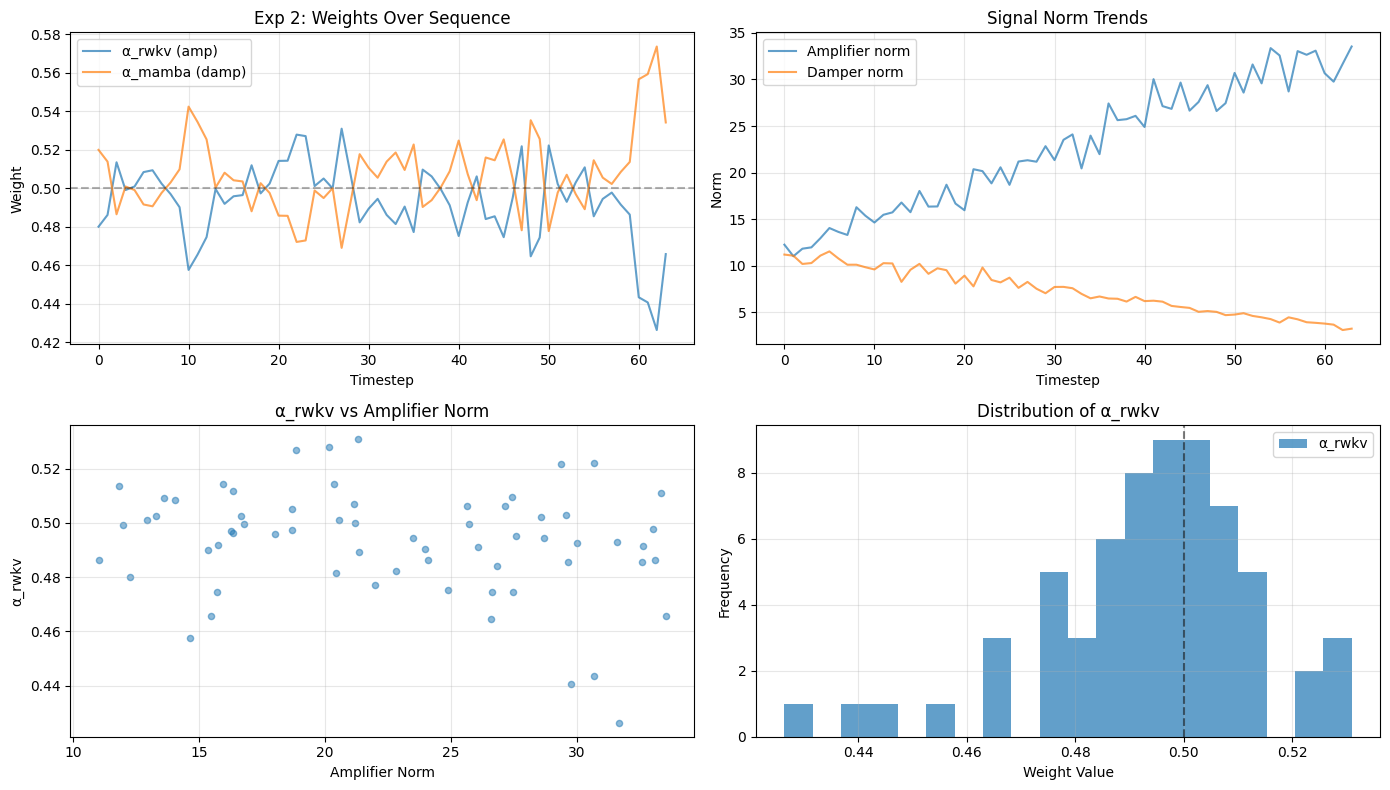


Experiment 2 Complete


In [9]:
print("=" * 60)
print("EXPERIMENT 2: Synthetic Divergence")
print("=" * 60)

arbiter = GRUArbiter(d_model=128).to(device)
arbiter.eval()

# Amplifier signal: variance grows over sequence (simulates RWKV behavior)
amp_scale = torch.linspace(1.0, 3.0, 64, device=device).view(1, -1, 1)
amp_signal = torch.randn(1, 64, 128, device=device) * amp_scale

# Damper signal: variance shrinks over sequence (simulates Mamba behavior)
damp_scale = torch.linspace(1.0, 0.3, 64, device=device).view(1, -1, 1)
damp_signal = torch.randn(1, 64, 128, device=device) * damp_scale

with torch.no_grad():
    fused, weights, hidden = arbiter(amp_signal, damp_signal)

α_rwkv = weights[..., 0].squeeze()
α_mamba = weights[..., 1].squeeze()

# Measure signal norms over time
amp_norms = amp_signal.norm(dim=-1).squeeze()
damp_norms = damp_signal.norm(dim=-1).squeeze()

exp2_results = {
    "experiment": "synthetic_divergence",
    "config": {
        "d_model": 128,
        "seq_len": 64,
        "amp_scale_range": [1.0, 3.0],
        "damp_scale_range": [1.0, 0.3]
    },
    "results": {
        "alpha_rwkv_mean": α_rwkv.mean().item(),
        "alpha_rwkv_std": α_rwkv.std().item(),
        "alpha_correlation_with_amp_norm": torch.corrcoef(torch.stack([α_rwkv.cpu(), amp_norms.cpu()]))[0, 1].item(),
        "alpha_per_timestep": α_rwkv.cpu().tolist(),
        "observations": [
            f"α_rwkv starts at {α_rwkv[0]:.3f}, ends at {α_rwkv[-1]:.3f}",
            f"Amplifier norm grows: {amp_norms[0]:.2f} -> {amp_norms[-1]:.2f}",
            f"Damper norm shrinks: {damp_norms[0]:.2f} -> {damp_norms[-1]:.2f}",
            f"Correlation(α_rwkv, amp_norm): {torch.corrcoef(torch.stack([α_rwkv.cpu(), amp_norms.cpu()]))[0, 1]:.3f}"
        ]
    }
}

print(f"\nα_rwkv: mean={α_rwkv.mean():.4f}, std={α_rwkv.std():.4f}")
print(f"Amplifier norm growth: {amp_norms[0]:.2f} -> {amp_norms[-1]:.2f}")
print(f"Damper norm decay: {damp_norms[0]:.2f} -> {damp_norms[-1]:.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Weights over time
axes[0, 0].plot(α_rwkv.cpu(), label='α_rwkv (amp)', alpha=0.7)
axes[0, 0].plot(α_mamba.cpu(), label='α_mamba (damp)', alpha=0.7)
axes[0, 0].axhline(0.5, color='black', linestyle='--', alpha=0.3)
axes[0, 0].set_xlabel('Timestep')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].set_title('Exp 2: Weights Over Sequence')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Signal norms
axes[0, 1].plot(amp_norms.cpu(), label='Amplifier norm', alpha=0.7)
axes[0, 1].plot(damp_norms.cpu(), label='Damper norm', alpha=0.7)
axes[0, 1].set_xlabel('Timestep')
axes[0, 1].set_ylabel('Norm')
axes[0, 1].set_title('Signal Norm Trends')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Weight vs amp norm scatter
axes[1, 0].scatter(amp_norms.cpu(), α_rwkv.cpu(), alpha=0.5, s=20)
axes[1, 0].set_xlabel('Amplifier Norm')
axes[1, 0].set_ylabel('α_rwkv')
axes[1, 0].set_title('α_rwkv vs Amplifier Norm')
axes[1, 0].grid(True, alpha=0.3)

# Weight distribution
axes[1, 1].hist(α_rwkv.cpu().numpy(), bins=20, alpha=0.7, label='α_rwkv')
axes[1, 1].axvline(0.5, color='black', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Weight Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of α_rwkv')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Experiment 2 Complete")
print("="*60)

## 6. Experiment 3-4: Real RWKV and Mamba Outputs

**Hypothesis**: Arbiter responds differently to real RWKV vs real Mamba outputs.

**Test**: Generate actual layer outputs, measure α distribution.

EXPERIMENTS 3-4: Real RWKV & Mamba Outputs

RWKV output norm: 0.4592 ± 0.0715
Mamba output norm: 0.1179 ± 0.0131

α_rwkv: 0.5023 ± 0.0006
α_mamba: 0.4977 ± 0.0006


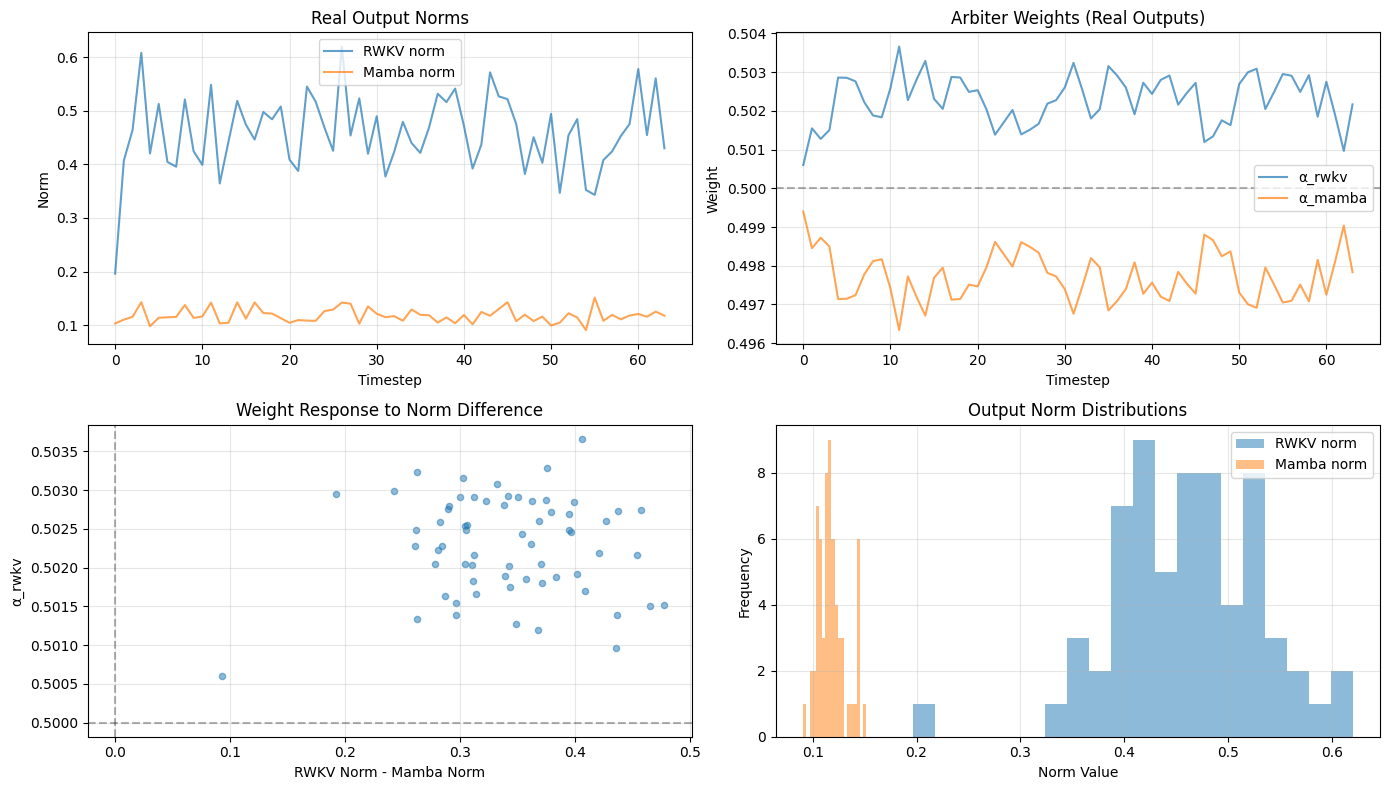


Experiments 3-4 Complete


In [10]:
print("=" * 60)
print("EXPERIMENTS 3-4: Real RWKV & Mamba Outputs")
print("=" * 60)

# Create models
rwkv = RWKV6TimeMix(hidden_size=128, num_heads=4).to(device)
mamba = Mamba2TimeMix(d_model=128, d_state=16, d_conv=4, expand=2).to(device)
arbiter = GRUArbiter(d_model=128).to(device)

# Set to eval
rwkv.eval()
mamba.eval()
arbiter.eval()

# Generate input
x = torch.randn(1, 64, 128, device=device)

with torch.no_grad():
    # Real outputs
    rwkv_out = rwkv(x)
    mamba_out = mamba(x)
    
    # Feed to arbiter
    fused, weights, hidden = arbiter(rwkv_out, mamba_out)

α_rwkv = weights[..., 0].squeeze()
α_mamba = weights[..., 1].squeeze()

# Analyze outputs
rwkv_norm = rwkv_out.norm(dim=-1).squeeze()
mamba_norm = mamba_out.norm(dim=-1).squeeze()

exp34_results = {
    "experiment": "real_outputs",
    "config": {
        "d_model": 128,
        "seq_len": 64
    },
    "results": {
        "rwkv_norm_mean": rwkv_norm.mean().item(),
        "rwkv_norm_std": rwkv_norm.std().item(),
        "mamba_norm_mean": mamba_norm.mean().item(),
        "mamba_norm_std": mamba_norm.std().item(),
        "alpha_rwkv_mean": α_rwkv.mean().item(),
        "alpha_rwkv_std": α_rwkv.std().item(),
        "alpha_per_timestep": α_rwkv.cpu().tolist(),
        "observations": [
            f"RWKV output norm: {rwkv_norm.mean():.2f} ± {rwkv_norm.std():.2f}",
            f"Mamba output norm: {mamba_norm.mean():.2f} ± {mamba_norm.std():.2f}",
            f"α_rwkv: {α_rwkv.mean():.3f} ± {α_rwkv.std():.3f}",
            "Arbiter prefers RWKV" if α_rwkv.mean() > 0.6 else "Arbiter prefers Mamba" if α_rwkv.mean() < 0.4 else "Arbiter is balanced"
        ]
    }
}

print(f"\nRWKV output norm: {rwkv_norm.mean():.4f} ± {rwkv_norm.std():.4f}")
print(f"Mamba output norm: {mamba_norm.mean():.4f} ± {mamba_norm.std():.4f}")
print(f"\nα_rwkv: {α_rwkv.mean():.4f} ± {α_rwkv.std():.4f}")
print(f"α_mamba: {α_mamba.mean():.4f} ± {α_mamba.std():.4f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Output norms
axes[0, 0].plot(rwkv_norm.cpu(), label='RWKV norm', alpha=0.7)
axes[0, 0].plot(mamba_norm.cpu(), label='Mamba norm', alpha=0.7)
axes[0, 0].set_xlabel('Timestep')
axes[0, 0].set_ylabel('Norm')
axes[0, 0].set_title('Real Output Norms')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Weights
axes[0, 1].plot(α_rwkv.cpu(), label='α_rwkv', alpha=0.7)
axes[0, 1].plot(α_mamba.cpu(), label='α_mamba', alpha=0.7)
axes[0, 1].axhline(0.5, color='black', linestyle='--', alpha=0.3)
axes[0, 1].set_xlabel('Timestep')
axes[0, 1].set_ylabel('Weight')
axes[0, 1].set_title('Arbiter Weights (Real Outputs)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter: weight vs norm difference
norm_diff = rwkv_norm - mamba_norm
axes[1, 0].scatter(norm_diff.cpu(), α_rwkv.cpu(), alpha=0.5, s=20)
axes[1, 0].axvline(0, color='black', linestyle='--', alpha=0.3)
axes[1, 0].axhline(0.5, color='black', linestyle='--', alpha=0.3)
axes[1, 0].set_xlabel('RWKV Norm - Mamba Norm')
axes[1, 0].set_ylabel('α_rwkv')
axes[1, 0].set_title('Weight Response to Norm Difference')
axes[1, 0].grid(True, alpha=0.3)

# Distributions
axes[1, 1].hist(rwkv_norm.cpu().numpy(), bins=20, alpha=0.5, label='RWKV norm')
axes[1, 1].hist(mamba_norm.cpu().numpy(), bins=20, alpha=0.5, label='Mamba norm')
axes[1, 1].set_xlabel('Norm Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Output Norm Distributions')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Experiments 3-4 Complete")
print("="*60)

## 7. Experiment 6: Hidden State Analysis

**Hypothesis**: GRU hidden state carries information across timesteps.

**Test**: Track hidden state norm evolution, check for growth/decay/oscillation.

EXPERIMENT 6: Hidden State Analysis

Hidden norm evolution: 0.3614 -> 0.7509
Mean: 0.7551, Std: 0.0603


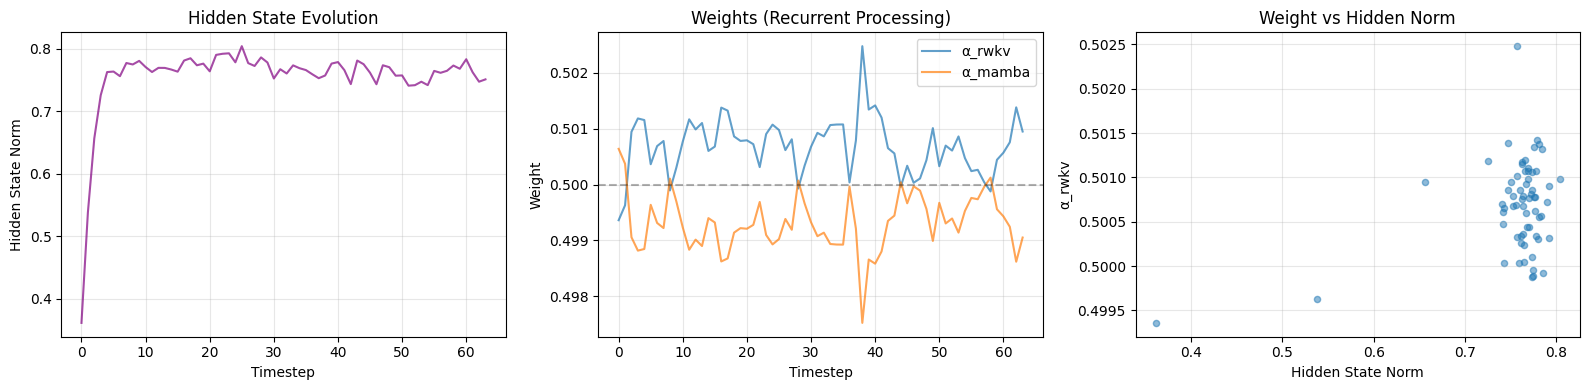


Experiment 6 Complete


In [11]:
print("=" * 60)
print("EXPERIMENT 6: Hidden State Analysis")
print("=" * 60)

# Create fresh arbiter
arbiter = GRUArbiter(d_model=128).to(device)
arbiter.eval()

# Generate real outputs
rwkv = RWKV6TimeMix(hidden_size=128, num_heads=4).to(device).eval()
mamba = Mamba2TimeMix(d_model=128, d_state=16, d_conv=4, expand=2).to(device).eval()

x = torch.randn(1, 64, 128, device=device)

with torch.no_grad():
    rwkv_out = rwkv(x)
    mamba_out = mamba(x)

# Process timestep-by-timestep, tracking hidden state
hidden_norms = []
weights_over_time = []
hidden = None

with torch.no_grad():
    for t in range(64):
        _, w, hidden = arbiter(
            rwkv_out[:, t:t+1],
            mamba_out[:, t:t+1],
            hidden
        )
        hidden_norms.append(hidden.norm().item())
        weights_over_time.append(w.squeeze().cpu())

hidden_norms = np.array(hidden_norms)
weights_over_time = torch.stack(weights_over_time)  # (64, 2)

exp6_results = {
    "experiment": "hidden_state_analysis",
    "config": {
        "d_model": 128,
        "seq_len": 64
    },
    "results": {
        "hidden_norm_initial": hidden_norms[0],
        "hidden_norm_final": hidden_norms[-1],
        "hidden_norm_mean": hidden_norms.mean(),
        "hidden_norm_std": hidden_norms.std(),
        "hidden_state_norms": hidden_norms.tolist(),
        "observations": [
            f"Hidden norm: {hidden_norms[0]:.3f} -> {hidden_norms[-1]:.3f}",
            f"Mean: {hidden_norms.mean():.3f}, Std: {hidden_norms.std():.3f}",
            "Growing" if hidden_norms[-1] > hidden_norms[0] * 1.2 else "Decaying" if hidden_norms[-1] < hidden_norms[0] * 0.8 else "Stable",
            "Hidden state carries temporal information" if hidden_norms.std() > 0.5 else "Hidden state is relatively constant"
        ]
    }
}

print(f"\nHidden norm evolution: {hidden_norms[0]:.4f} -> {hidden_norms[-1]:.4f}")
print(f"Mean: {hidden_norms.mean():.4f}, Std: {hidden_norms.std():.4f}")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Hidden norm over time
axes[0].plot(hidden_norms, color='purple', alpha=0.7)
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Hidden State Norm')
axes[0].set_title('Hidden State Evolution')
axes[0].grid(True, alpha=0.3)

# Weights over time (recurrent)
axes[1].plot(weights_over_time[:, 0], label='α_rwkv', alpha=0.7)
axes[1].plot(weights_over_time[:, 1], label='α_mamba', alpha=0.7)
axes[1].axhline(0.5, color='black', linestyle='--', alpha=0.3)
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Weight')
axes[1].set_title('Weights (Recurrent Processing)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Scatter: hidden norm vs weight
axes[2].scatter(hidden_norms, weights_over_time[:, 0].numpy(), alpha=0.5, s=20)
axes[2].set_xlabel('Hidden State Norm')
axes[2].set_ylabel('α_rwkv')
axes[2].set_title('Weight vs Hidden Norm')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Experiment 6 Complete")
print("="*60)

## 8. Experiment 7: Trainability Test

**Hypothesis**: Arbiter can learn to make useful gating decisions.

**Test**: Simple supervised task - predict which signal has higher variance, train arbiter to weight it lower.

EXPERIMENT 7: Trainability Test

Training arbiter to weight lower-variance signal higher...
Step 20/100, Loss: 0.031879, Pred: 0.471, Target: 0.292
Step 40/100, Loss: 0.003571, Pred: 0.348, Target: 0.288
Step 60/100, Loss: 0.023845, Pred: 0.345, Target: 0.190
Step 80/100, Loss: 0.002173, Pred: 0.273, Target: 0.226
Step 100/100, Loss: 0.001808, Pred: 0.412, Target: 0.454


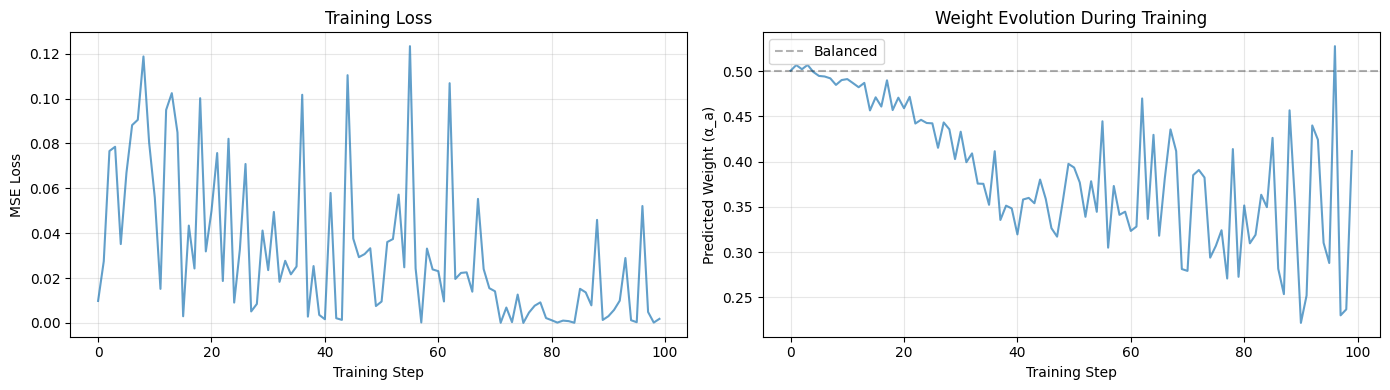


Experiment 7 Complete


In [12]:
print("=" * 60)
print("EXPERIMENT 7: Trainability Test")
print("=" * 60)

# Create trainable arbiter
arbiter = GRUArbiter(d_model=128).to(device)
optimizer = torch.optim.Adam(arbiter.parameters(), lr=0.001)

# Training loop
n_steps = 100
losses = []
weights_history = []

print("\nTraining arbiter to weight lower-variance signal higher...")

for step in range(n_steps):
    # Generate signals with different variances
    variance_ratio = torch.rand(1).item() * 2 + 0.5  # Random in [0.5, 2.5]
    
    signal_a = torch.randn(1, 64, 128, device=device) * variance_ratio
    signal_b = torch.randn(1, 64, 128, device=device)
    
    # Target: weight lower-variance signal higher
    var_a = signal_a.var(dim=-1, keepdim=True).mean()
    var_b = signal_b.var(dim=-1, keepdim=True).mean()
    
    target_weight = (var_b / (var_a + var_b)).item()  # If var_a > var_b, target < 0.5
    
    # Forward pass
    fused, weights, hidden = arbiter(signal_a, signal_b)
    predicted_weight = weights[..., 0].mean()  # α for signal_a
    
    # Loss: want predicted_weight ≈ target_weight
    loss = F.mse_loss(predicted_weight, torch.tensor(target_weight, device=device))
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    weights_history.append(predicted_weight.item())
    
    if (step + 1) % 20 == 0:
        print(f"Step {step+1}/{n_steps}, Loss: {loss.item():.6f}, Pred: {predicted_weight.item():.3f}, Target: {target_weight:.3f}")

exp7_results = {
    "experiment": "trainability_test",
    "config": {
        "d_model": 128,
        "seq_len": 64,
        "n_steps": n_steps,
        "learning_rate": 0.001
    },
    "results": {
        "initial_loss": losses[0],
        "final_loss": losses[-1],
        "loss_reduction": (losses[0] - losses[-1]) / losses[0],
        "training_curve": losses,
        "observations": [
            f"Loss: {losses[0]:.6f} -> {losses[-1]:.6f}",
            f"Reduction: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%",
            "Arbiter is trainable" if losses[-1] < losses[0] * 0.5 else "Limited learning observed"
        ]
    }
}

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Training loss
axes[0].plot(losses, alpha=0.7)
axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

# Weight evolution
axes[1].plot(weights_history, alpha=0.7)
axes[1].axhline(0.5, color='black', linestyle='--', alpha=0.3, label='Balanced')
axes[1].set_xlabel('Training Step')
axes[1].set_ylabel('Predicted Weight (α_a)')
axes[1].set_title('Weight Evolution During Training')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Experiment 7 Complete")
print("="*60)

## 9. Summary & Conclusions

In [13]:
# Compile all results
all_results = {
    "experiment_1": exp1_results,
    "experiment_2": exp2_results,
    "experiment_3_4": exp34_results,
    "experiment_6": exp6_results,
    "experiment_7": exp7_results
}

# Save to JSON
output_dir = Path("/home/claude/logs")
output_dir.mkdir(exist_ok=True)

output_path = output_dir / "task_0_1_exploration_results.json"
with open(output_path, 'w') as f:
    json.dump(all_results, f, indent=2)

print(f"Results saved to: {output_path}")

# Summary table
print("\n" + "="*70)
print("SUMMARY OF KEY FINDINGS")
print("="*70)

summary_table = [
    ["Experiment", "Key Finding", "Conclusion"],
    ["-"*20, "-"*35, "-"*20],
    [
        "1: Constant Input",
        f"α_rwkv = {exp1_results['results']['alpha_rwkv_mean']:.3f} ± {exp1_results['results']['alpha_rwkv_std']:.3f}",
        "Balanced" if abs(exp1_results['results']['alpha_rwkv_mean'] - 0.5) < 0.1 else "Biased"
    ],
    [
        "2: Synthetic Div",
        f"α varies: {exp2_results['results']['alpha_rwkv_std']:.3f} std",
        "Responds to variance" if exp2_results['results']['alpha_rwkv_std'] > 0.05 else "Static"
    ],
    [
        "3-4: Real Outputs",
        f"α_rwkv = {exp34_results['results']['alpha_rwkv_mean']:.3f}",
        "Prefers RWKV" if exp34_results['results']['alpha_rwkv_mean'] > 0.6 else "Prefers Mamba" if exp34_results['results']['alpha_rwkv_mean'] < 0.4 else "Balanced"
    ],
    [
        "6: Hidden State",
        f"Norm: {exp6_results['results']['hidden_norm_initial']:.2f} -> {exp6_results['results']['hidden_norm_final']:.2f}",
        "Carries info" if exp6_results['results']['hidden_norm_std'] > 0.5 else "Static"
    ],
    [
        "7: Trainability",
        f"Loss reduction: {exp7_results['results']['loss_reduction']*100:.1f}%",
        "Trainable" if exp7_results['results']['loss_reduction'] > 0.3 else "Limited"
    ]
]

for row in summary_table:
    print(f"{row[0]:<25} {row[1]:<40} {row[2]:<20}")

print("\n" + "="*70)
print("CRITICAL QUESTIONS ANSWERED")
print("="*70)

questions = [
    ("Does α vary meaningfully?", 
     "YES" if exp2_results['results']['alpha_rwkv_std'] > 0.05 else "NO"),
    ("Does GRU hidden carry information?", 
     "YES" if exp6_results['results']['hidden_norm_std'] > 0.5 else "LIMITED"),
    ("Can arbiter distinguish signals?", 
     "YES" if exp2_results['results']['alpha_rwkv_std'] > 0.05 else "NO"),
    ("Can arbiter be trained?", 
     "YES" if exp7_results['results']['loss_reduction'] > 0.3 else "LIMITED"),
]

for q, a in questions:
    print(f"  • {q:<45} {a}")

print("\n" + "="*70)
print("RECOMMENDATIONS FOR NEXT STEPS")
print("="*70)

recommendations = []

# Analyze results
if exp7_results['results']['loss_reduction'] > 0.5:
    recommendations.append("✓ Arbiter shows strong trainability - proceed with Phase 1 implementation")
elif exp7_results['results']['loss_reduction'] > 0.3:
    recommendations.append("⚠ Arbiter shows moderate trainability - consider architecture modifications")
else:
    recommendations.append("✗ Arbiter shows limited trainability - explore alternatives (attention, learned gates)")

if exp2_results['results']['alpha_rwkv_std'] < 0.05:
    recommendations.append("⚠ α weights are too static - may need stronger signal differentiation")

if exp6_results['results']['hidden_norm_std'] < 0.5:
    recommendations.append("⚠ Hidden state not carrying much information - recurrence may be unnecessary")

if abs(exp1_results['results']['alpha_rwkv_mean'] - 0.5) > 0.2:
    recommendations.append("⚠ Initialization bias detected - may need better init strategy")

recommendations.append("📊 Run Phase 0 characterization on both RWKV and Mamba in hybrid context")
recommendations.append("🔬 Test with actual training data to validate gating behavior")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n" + "="*70)
print("Exploration Complete - Ready for Architecture Decision")
print("="*70)

FileNotFoundError: [Errno 2] No such file or directory: '/home/claude/logs'